In [146]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import community
from matplotlib import cm
from funciones import *

In [147]:
#------------------------------------------------------------------------------------------------------
#                                 Trabajo Computacional 3
#------------------------------------------------------------------------------------------------------

# Primero creamos la red de delfines: agregamos los enlaces sin necesidad de agregar antes los nodos
mydolphins = nx.read_gml('dolphins.gml')

# Para agregar el dato del genero a partir del txt:
# creamos dos listas: una de nombres de delfines (nodos) y otra de los generos correspondientes
Gender = pd.read_csv('dolphinsGender.txt', sep='\t', header=None)
delfines = Gender[0] # nombres de delfines (nodos)
genero = Gender[1]   # genero de los delfines en el mismo orden que los nodos

# A cada uno de los nodos ya existentes en el grafo, se le agrega el genero
for d,g in zip(delfines,genero):
    mydolphins.add_node(d, gender=g)

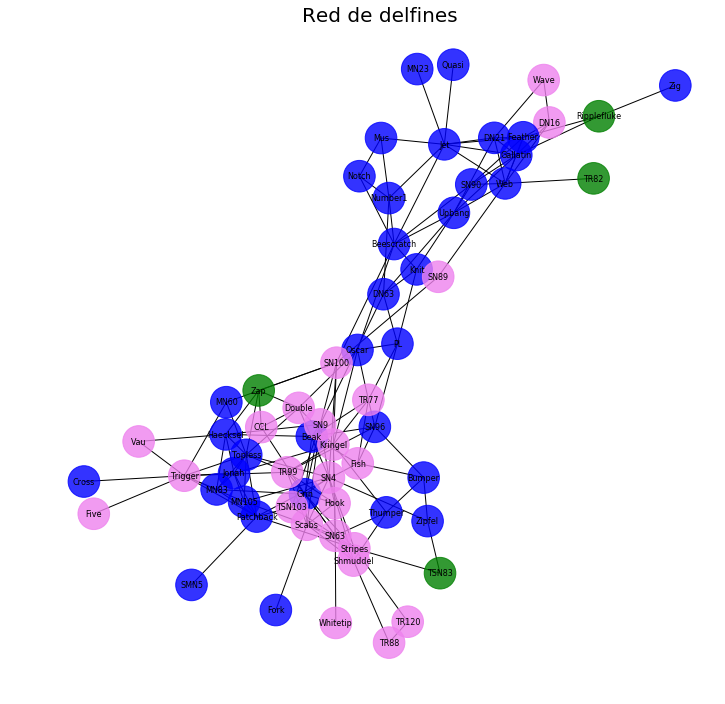

In [148]:
#------------------------------------------------------------------------------------------------------
#Grafico Original
#------------------------------------------------------------------------------------------------------
width=12
height=12
fig=plt.figure(figsize=(width, height))
fig.patch.set_facecolor('white')
pos = nx.spring_layout(mydolphins)

#Nodos
nx.draw_networkx_nodes(mydolphins,
                       pos,
                       nodelist=mydolphins.nodes(),
                       node_color=["blue" if g=="m" else "violet" if g=="f" else "green" for g in nx.get_node_attributes(mydolphins, "gender").values()],
                       with_labels=True,node_size=1000,alpha=0.8)

#Enlaces
nx.draw_networkx_edges(mydolphins,pos,width=1.0,alpha=1)

#Etiquetas
nx.draw_networkx_labels(mydolphins,pos,font_size=8)
plt.title('Red de delfines',fontsize=20)
plt.axis('off')
plt.show()

In [149]:
#------------------------------------------------------------------------------------------------------
#Metodo: Louvain
#------------------------------------------------------------------------------------------------------
G=mydolphins.copy()
part = community.best_partition(G) # diccionario con nodo - comunidad (nro)

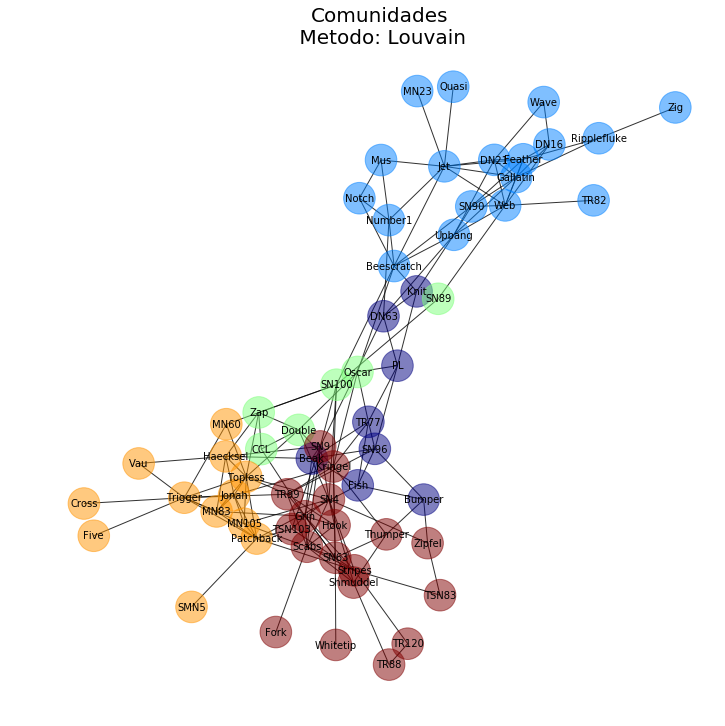

In [150]:
#------------------------------------------------------------------------------------------------------
#Visualizo comunidades
#------------------------------------------------------------------------------------------------------
comunidades=list(part.values())#lista de comunidades desordenada y repetidas
L=len(comunidades)#cantidad de nodos
a=np.unique(comunidades)
l=len(a) #cantidad de comunidades
delfines = G.nodes()

colores_com = np.linspace(0,1,l) # quiero n colores
colores = [ cm.jet(x) for x in colores_com ] # transformo en colores del colormap que quiera

width=12
height=12
fig=plt.figure(figsize=(width, height))
fig.patch.set_facecolor('white')

nx.draw_networkx_nodes(G,pos,
                       node_color = [colores[g] for g in part.values()],
                       node_size=1000,
                       alpha=0.5)

nx.draw_networkx_edges(G,pos,width=1.0,
                       alpha=0.8)
#Etiquetas
nx.draw_networkx_labels(mydolphins,pos,font_size=10)
plt.title('Comunidades\n Metodo: Louvain',fontsize=20)
plt.axis('off')

plt.show()

In [151]:
#------------------------------------------------------------------------------------------------------
#Caracterización de Modularidad y Silhouette
#------------------------------------------------------------------------------------------------------
#Modularidad Total:
#-------------------------------------------------------------
#Matriz de Adyacencias Aij:
A = np.array(nx.to_numpy_matrix(G,nodelist=delfines))
N=G.number_of_nodes()
m=G.number_of_edges()
grado = dict(G.degree())

#Matriz de variable categorica comunidad: Cij=delta(ci,cj)
C=np.zeros(np.shape(A))
for i,com_i in enumerate(comunidades):
    for j,com_j in enumerate(comunidades):
        if (com_i==com_j):
            C[i,j]=1
            
#Calculo de la modularidad
#Q/Qmax=(S1-S2)*(1/2m)
#S1=Suma en nodos (Aij*Cij)
#S2=Suma en nodos(kikj*Cij/2m)
S1=0
S2=0
for ni, delfin_i in enumerate(delfines):
    for nj, delfin_j in enumerate(delfines):  
        S1=S1+A[ni,nj]*C[ni,nj]
        S2=S2+grado[delfin_i]*grado[delfin_j]*C[ni,nj]
S2=S2/(2*m)
mod_tot=(S1-S2)/(2*m)

print('Modularidad Total = {0:.3f}'.format(mod_tot))

#------------------------------------------------------------------------------------------------------
#Modularidad de cada Partición:
#-------------------------------------------------------------

#Calculando la modularidad de cada comunidad:
modularidades=[]

for com in a:
    S1=0
    S2=0
    for ni, delfin_i in enumerate(delfines):
        for nj, delfin_j in enumerate(delfines):
            if com == list(part.values())[ni]:
                S1=S1+A[ni,nj]*C[ni,nj]
                S2=S2+grado[delfin_i]*grado[delfin_j]*C[ni,nj]

    S2=S2/(2*m)
    mod=(S1-S2)/(2*m)
    modularidades.append(float(mod))
    

ls= [round(x, 3) for x in modularidades]

print('Modularidades por comunidad = ')
print(ls)

#Checkeo 
#print('Modularidad = {0:.3f}'.format(np.sum(modularidades)))

Modularidad Total = 0.519
Modularidades por comunidad = 
[0.065, 0.171, 0.03, 0.11, 0.142]


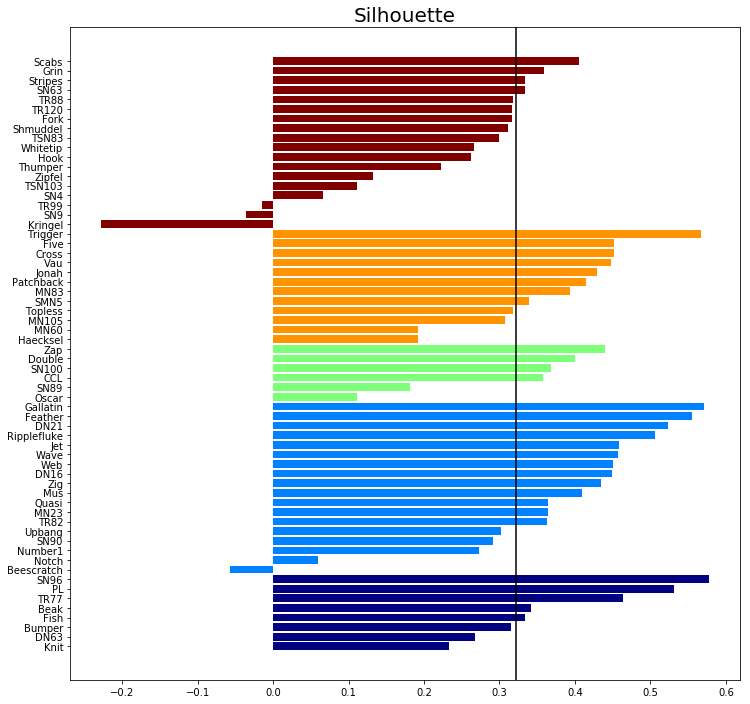

Valor promedio de Silhouette 0.32216956587829915


In [152]:
#------------------------------------------------------------------------------------------------------
#Silhouette:
#-------------------------------------------------------------
#Nota importante: list(part.keys())[i] representa el delfin en el lugar i-ésimo y comunidades es la lista de las comunidades de cada delfin
#Y que list(part.values())[i] representa la comunidad a la q pertenece

#Calculo a[i]
a=[] #contendra para cada nodo en delfines la distancia promedio a nodos de su misma comunidad
for i,delfin_i in enumerate(delfines):
    distancias=[]
    for j, delfin_j in enumerate(delfines):
        if list(part.values())[i]==list(part.values())[j]:
               distancias.append(len(nx.shortest_path(G,delfin_i,delfin_j))-1)         
    promedio=np.mean(distancias)
    a.append(promedio)


#Calculo b[i]
b=[] #contendria para cada delfin la distancia promedio a nodos de otras comunidades, devuelvo el promedio minimo
ls=np.unique(comunidades)
for i,delfin_i in enumerate(delfines):
    distancias_prom=[] #es la lista q tiene mis distancias minimas 
    for c in ls: #recorro las comunidades
        distancias=[] #armo una lista que me indique las distancias por comunidad
        for j, delfin_j in enumerate(delfines): #recorro nuevamente para comparar
            if (list(part.values())[i]!=list(part.values())[j] and list(part.values())[j]==c): #Busco de forma ordenada los delfines
                #distancias.append((c, com_i, com_j,len(nx.shortest_path(G,list(part.keys())[i],list(part.keys())[j]))-1)) #esto es para ver si funcionaba bien
                distancias.append(len(nx.shortest_path(G,delfin_i,delfin_j))-1)
        if len(distancias)!=0: #hay algunos c para los cuales la lista queda vacia
            distancias_prom.append(np.mean(distancias))
        
    b.append(min(distancias_prom))

#Calculo Silhouette    
S=[]
for i,com_i in enumerate(comunidades):
    s=(b[i]-a[i])/(max(b[i],a[i]))
    S.append(s)
    #guardo la propiedad silhouette en el grafo:
    G.node[list(part.keys())[i]]['silhouette']=s

#-------------------------------------------------------------
#Grafico Silhouette:
width=12
height=12
plt.figure(figsize=(width, height))
delfines=np.sort(delfines)
y = []
yTicks = []
contador=-1
dtype = [('name', 'S21'),('silhouette', float)]
a=np.unique(comunidades)
for c in a:
    delf_S=[] #lista con pares de [delfin,silouette]
    for i,com_i in enumerate(comunidades): 
        if com_i==c:
            delf_S.append((str(list(part.keys())[i]),G.nodes[list(part.keys())[i]]['silhouette']))        
    delf_S=np.array(delf_S,dtype=dtype)
    delf_S=np.sort(delf_S,order='silhouette') #lo ordeno segun la propiedad silhouette
    delf_S=list(delf_S)
    
    for j,d in enumerate(delf_S):
        contador=contador+1
        delfin=str(delf_S[j][0],'utf-8')
        silhouette_value=delf_S[j][1]
        plt.barh(contador,silhouette_value,color = colores[c])#grafico una barra
        y.append(contador)
        yTicks.append(delfin)
plt.yticks(y, yTicks)
plt.yticks(range(len(delfines)),yTicks)
plt.axvline(np.mean(S), c="black",label='Red real')
plt.title('Silhouette',fontsize=20)
plt.show()
print('Valor promedio de Silhouette',np.mean(S))

C:\Users\Lucio\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


TypeError: object of type 'float' has no len()

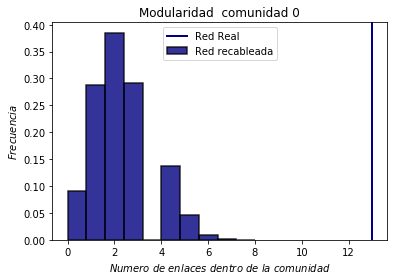

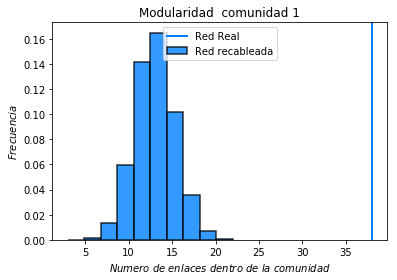

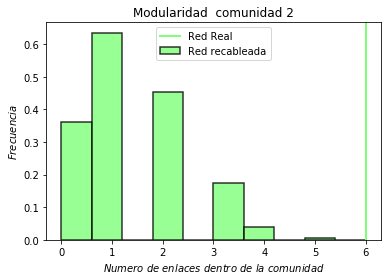

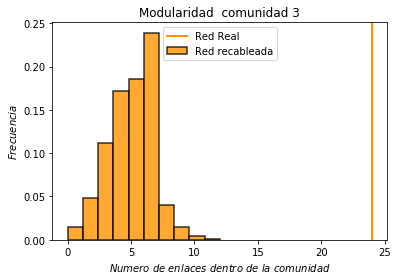

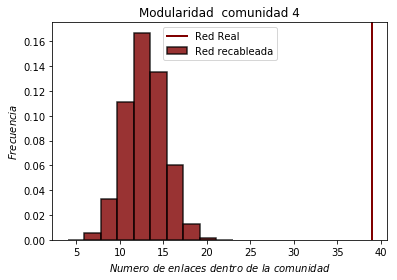

In [153]:
#------------------------------------------------------------------------------
#Rewiring:
#------------------------------------------------------------------------------
#Se podria tomar la red original recablear, y luego para las comunidades encontradas
#en la red original contar los enlaces que se hayan entre esos nodos.
#O sea estariamos calculando de forma simulada el valor kikj/2L.
#Haremos un histograma del numero de enlaces en esa comunidad.

G=mydolphins.copy()
Recableados={} #es un diccionario que tiene como keys ['comunidadi'] y como propiedades['color','lc_real','lc_random'].
               #lc_random es una lista de tamano 'iteraciones' y que contiene el numero de enlaces dentro de esa comunidadn uno de esos recableados

a=np.unique(comunidades) #a es un vector que tiene las comunidades [0,1,2,3,4]
lc_random=[]
for c in a:
    lc_random.append([])

#Recableamos y contamos enlaces en cada comunidad

iteraciones=20000 #descomentar para que corra
for it in range(0,iteraciones):
    D=rewiring(G) #creamos un nuevo grafo recableado:
    D_ady = np.array(nx.to_numpy_matrix(D,nodelist=delfines))
    for c in a:
        enlaces=0
        for ni, delfin_i in enumerate(delfines):
            for nj, delfin_j in enumerate(delfines):
                if c==list(part.values())[ni] == list(part.values())[nj]:
                    enlaces=enlaces+D_ady[ni,nj]
        lc_random[c].append(int(enlaces)/2)
        Recableados['comunidad'+str(c)]={'color':colores[c],'lc_real':0,'lc_random':list(lc_random[c])}

#Contamos enlaces en cada comunidad de la red original:
#modularidad_rewiring
for c in a:
    enlaces=0
    for ni, delfin_i in enumerate(delfines):
        for nj, delfin_j in enumerate(delfines):
            if c==list(part.values())[nj] == list(part.values())[ni]:
                enlaces=enlaces+A[ni,nj]
    enlaces=int(enlaces)/2
    Recableados['comunidad'+str(c)]['lc_real']=enlaces

#Graficamos:
outfolder ='C:/Users/Lucio/Desktop/FACULTAD/Redes/datos/datosTP3/'

for c in a:
    plt.figure(c)
    plt.hist(Recableados['comunidad'+str(c)]['lc_random'],color=colores[c],linewidth=1.5,edgecolor='black',label='Red recableada',alpha=0.8,normed=1)
    plt.axvline(x=Recableados['comunidad'+str(c)]['lc_real'],color=colores[c],linewidth=2,label='Red Real')
    plt.xlabel('$Numero$ $de$ $enlaces$ $dentro$ $de$ $la$ $comunidad$')
    plt.ylabel('$Frecuencia$')
    plt.legend(loc='upper center')
    plt.title('Modularidad '+' comunidad '+str(c))
    plt.savefig(outfolder+'comunidad_'+str(c)+'_hist.png')


#Output
for c in a:
    lc_real=Recableados['comunidad'+str(c)]['lc_real'] #numero de enlaces dentro de la comunidad en la red real
    lc_rewiring=np.mean(Recableados['comunidad'+str(c)]['lc_random'])#numero de enlaces promedio dentro de la comunidad para un cierto numero de redes recableadas.
    modularidad_por_rewiring=(lc_real-lc_rewiring)/m #dividimos por el numero de enlaces totales.
    output={}
    output['comunidad']=Recableados['comunidad'+str(c)]['color']
    output['enlaces_red_real']=lc_real
    output['enlaces_red_recabelada']=lc_rewiring
    output['modularidad por rewiring']=modularidad_por_rewiring
    output['modularidad por cuenta teorica']=modularidades[c]
    output['enlaces_red_random']=list(Recableados['comunidad'+str(c)]['lc_random'])
    df = pd.DataFrame.from_dict(output, orient='index')
    df.to_csv(outfolder+'comunidad_'+str(c)+'_data.txt',sep='\t')


 

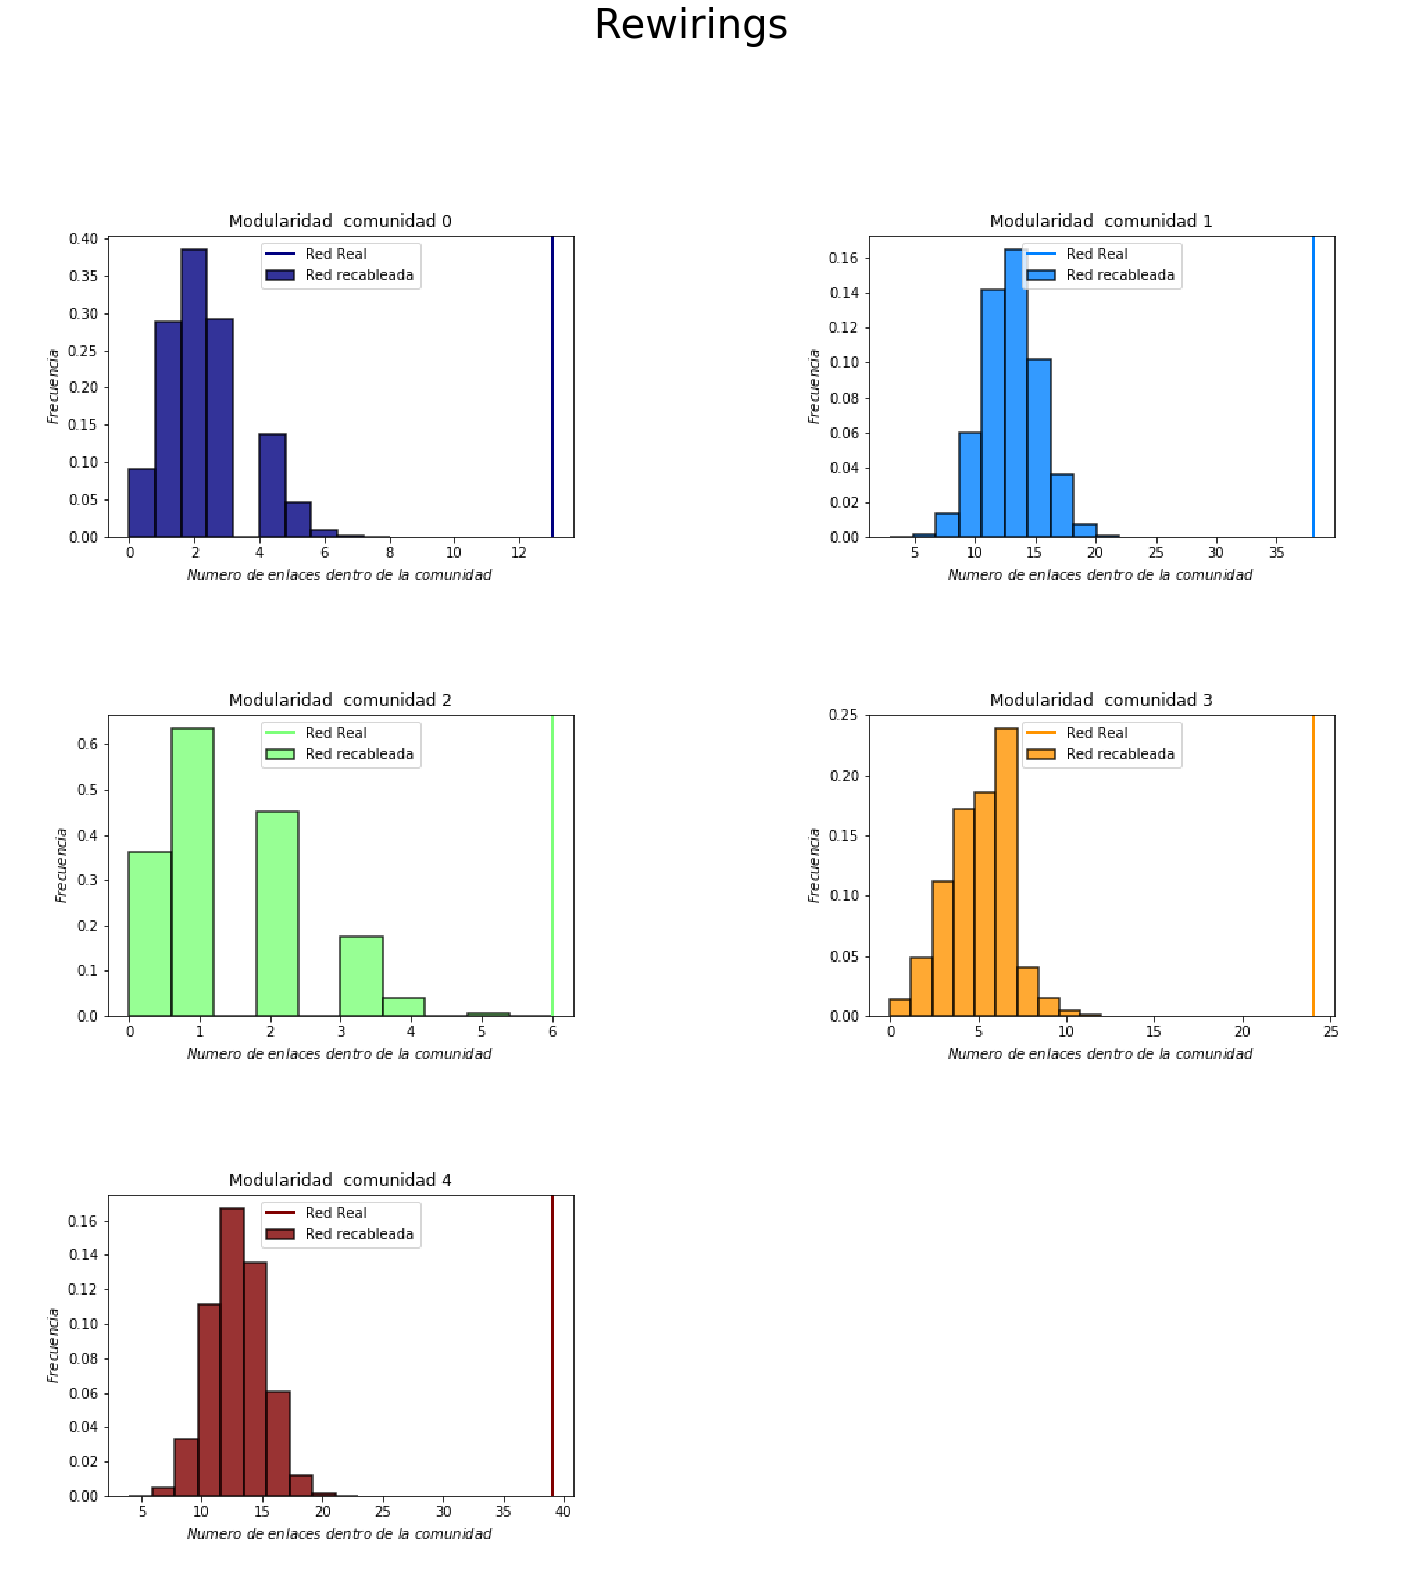

In [220]:
plt.figure(figsize=(25,25))
plt.suptitle('Rewirings',fontsize=40)

plt.subplot(3,2,1)
#fig0=plt.figure(figsize=(8,8))
comunidad_0=plt.imread('C:/Users/Lucio/Desktop/FACULTAD/Redes/datos/datosTP3/comunidad_0_hist.png')
plt.imshow(comunidad_0)
plt.axis('off')

plt.subplot(3,2,2)
comunidad_1=plt.imread('C:/Users/Lucio/Desktop/FACULTAD/Redes/datos/datosTP3/comunidad_1_hist.png')
plt.imshow(comunidad_1)
plt.axis('off')

plt.subplot(3,2,3)
comunidad_2=plt.imread('C:/Users/Lucio/Desktop/FACULTAD/Redes/datos/datosTP3/comunidad_2_hist.png')
plt.imshow(comunidad_2)
plt.axis('off')

plt.subplot(3,2,4)
comunidad_3=plt.imread('C:/Users/Lucio/Desktop/FACULTAD/Redes/datos/datosTP3/comunidad_3_hist.png')
plt.imshow(comunidad_3)
plt.axis('off')

plt.subplot(3,2,5)
comunidad_4=plt.imread('C:/Users/Lucio/Desktop/FACULTAD/Redes/datos/datosTP3/comunidad_4_hist.png')
plt.imshow(comunidad_4)
plt.axis('off')

plt.show()

